In [4]:
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import get_window
import matplotlib.mlab as mlab
from statsmodels.tsa.stattools import acf
import scipy
from statsmodels.graphics.tsaplots import plot_acf
import pycbc
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, matched_filter
from pycbc.filter import highpass
from pycbc.psd import welch
from pycbc.waveform.generator import FDomainCBCGenerator
from pycbc import types, fft
from pycbc.conversions import mass1_from_mchirp_q, mass2_from_mchirp_q
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.filter import resample_to_delta_t
from pycbc.filter import sigma
from tqdm import tqdm

In [5]:
array = np.loadtxt("H-H1_GWOSC_4KHZ_R1-1126257415-4096.txt")

In [4]:
np.mean(array)

-1.406406721129966e-23

In [43]:
np.std(array)

2.1131710098642665e-19

In [119]:
strain = TimeSeries(array, t0=1126257415, sample_rate=4096, unit='strain',delta_t=)

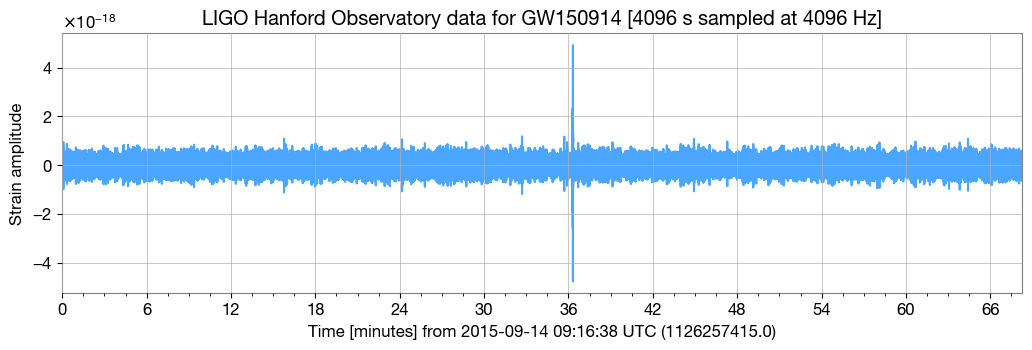

In [69]:
plot = strain.plot(
    title="LIGO Hanford Observatory data for GW150914 [4096 s sampled at 4096 Hz]",
    ylabel="Strain amplitude",
    color="gwpy:ligo-livingston",
    epoch=1126257415,
)
plot.show()

In [26]:
numero = 4096*4096

divisori = []
for i in range(1, numero + 1):
    if numero % i == 0:
        if i > 1000:
            divisori.append(i)

del divisori[-2:]
print("Divisori di", numero, ":", divisori)

Divisori di 16777216 : [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304]


In [327]:
a = np.array([3, 0, 3, 7])

In [329]:
b = scipy.stats.mode(a)

In [331]:
scipy.stats.mode(a)[0]

3

In [333]:
for numero in divisori:
    print(numero)
    #fig, axarr = plt.subplots(1, 2,figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1]})
    tmp_series = np.reshape(array,(numero,int(len(array)/numero)))
    mean_series = np.mean(tmp_series,axis=0)
    Rs = np.cov(tmp_series,rowvar=False,bias=True)
    for i in range(int(len(array)/numero)):
        a = np.array(Rs.diagonal(i))
        #print(a)
        b = np.array(Rs.diagonal(-i))
        #print(b)
        c = np.concatenate([a,b])
        d = np.isclose(c, scipy.stats.mode(c)[0],rtol=1e-1,atol=0,equal_nan=True)
        e=d.sum()/len(d)
        if e<0.75:
            print("Not a WSS process!")
            break
            
    #axarr[1].matshow(Rs)
    #axarr[1].colorbar()
    #axarr[1].xaxis.set_ticks_position('bottom')
    #axarr[1].set_xlabel('i index')
    #axarr[1].set_ylabel('j index')
    #axarr[1].set_title('Autocovariance')
    #axarr[0].plot(np.linspace(0,int(len(array)/numero)/4096,int(len(array)/numero)),mean_series)
    #axarr[0].set_xlabel('time [s]')
    #axarr[0].set_ylabel('mean strain')
    #axarr[0].set_title(f'Mean function')
    #fig.suptitle(f'Statistics for {int(len(array)/numero)/4096} s long strain, mediated over {numero} samples')
    #fig.tight_layout()
    #fig.subplots_adjust(top=0.8)
    #plt.savefig(f'stat{int(len(array)/numero)/4096}_s_new.pdf')
    #plt.show()

1024
Not a WSS process!
2048
Not a WSS process!
4096
Not a WSS process!
8192
Not a WSS process!
16384
Not a WSS process!
32768
Not a WSS process!
65536
Not a WSS process!
131072
262144
524288
1048576
2097152
4194304


In [344]:
# Definizione delle dimensioni dei chunk e dello spaziamento
chunk_size = 16 * 4096
spacing = (128-16) * 4096

# Calcolo del numero totale di chunk
num_chunks = len(array) // (chunk_size + spacing)
print(num_chunks)
# Creazione di una lista di chunk
chunks = [array[i * (chunk_size + spacing): (i + 1) * chunk_size + i * spacing] for i in range(num_chunks)]

32


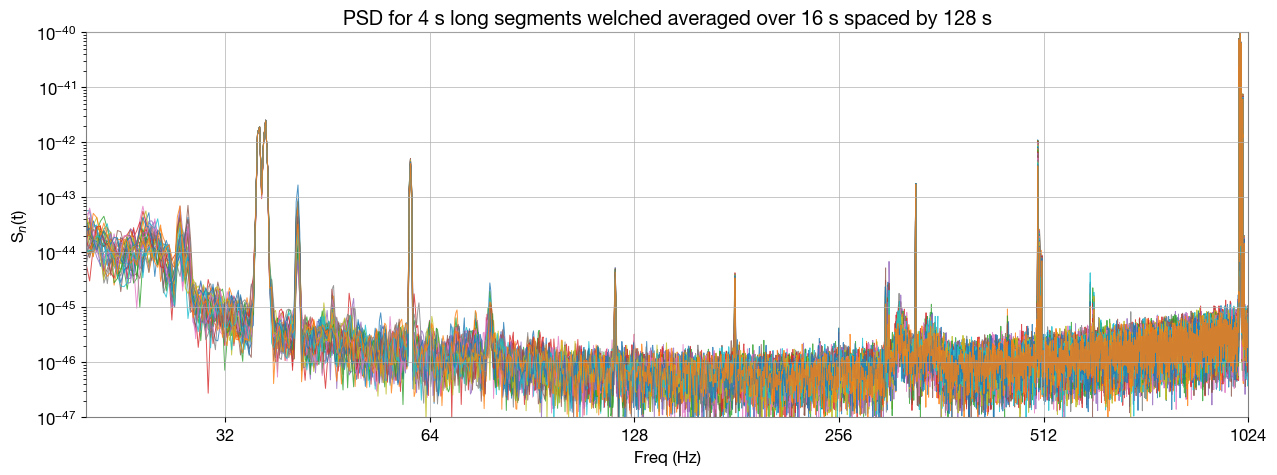

In [347]:
fs = 4096
NFFT = 4 * fs           # Use 4 seconds of data for each fourier transform
NOVL = 1 * NFFT / 2     # The number of points of overlap between segments used in Welch averaging
psd_window_hann = scipy.signal.windows.hann(NFFT,sym=False)
plt.figure(figsize=(15, 5))
ax = plt.axes()
# scale x and y axes
plt.xscale('log', base=2)
plt.yscale('log', base=10)
for chunk in chunks:
    hann_Pxx_H1, hann_freqs = mlab.psd(chunk, Fs=fs, NFFT=NFFT, window=psd_window_hann)
    plt.plot(hann_freqs, hann_Pxx_H1,
                      alpha=.8, linewidth=.7)
plt.axis([20, 1024, 1e-47, 1e-40])
plt.ylabel(r'S$_n$(t)')
plt.xlabel('Freq (Hz)')
    # ax.minorticks_on()
ax.tick_params(axis='x', which='minor', direction='out')
    # ax.minorticks_on()
#plt.legend(loc='best')
plt.title('PSD for 4 s long segments welched averaged over 16 s spaced by 128 s')
#plt.savefig('psd_stretch.pdf')
plt.show()

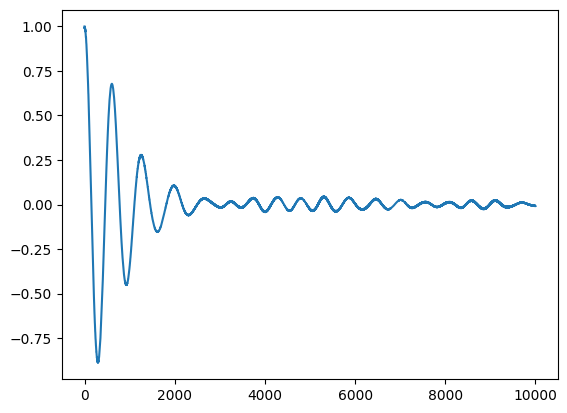

In [12]:
acf_array = acf(array, fft=True, nlags=10000)
plt.plot(acf_array)
plt.show()

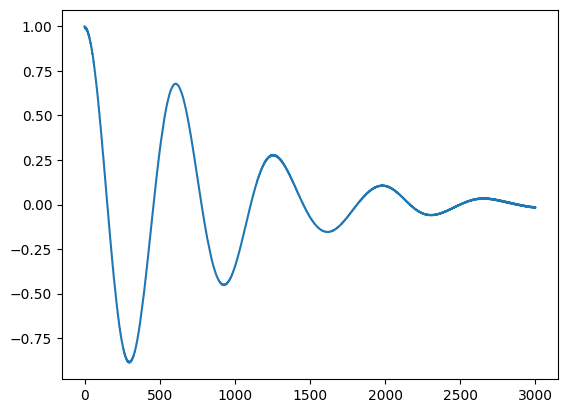

In [13]:
acf_array = acf(array, fft=True, nlags=3000)
plt.plot(acf_array)
plt.show()

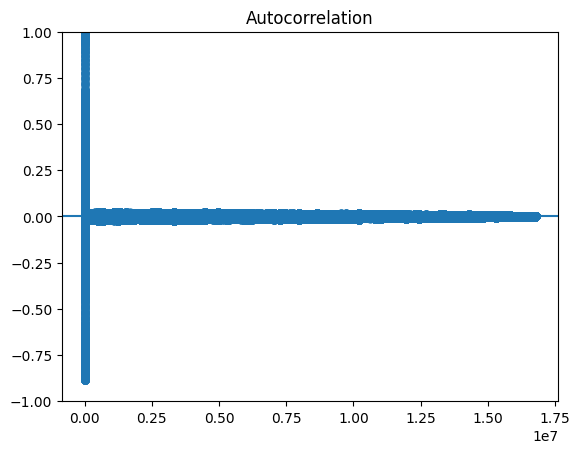

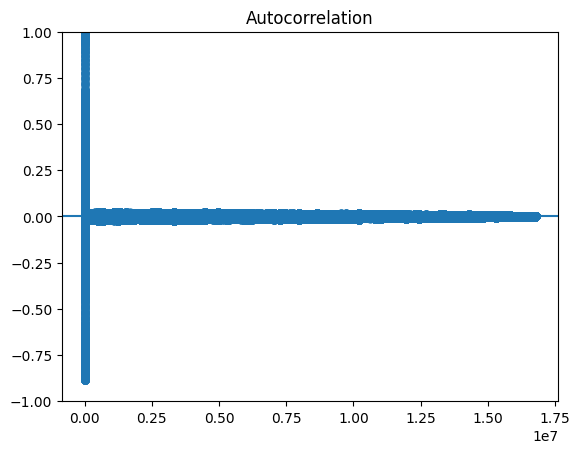

In [6]:
plot_acf(array,fft=True,lags=np.arange(len(array)))

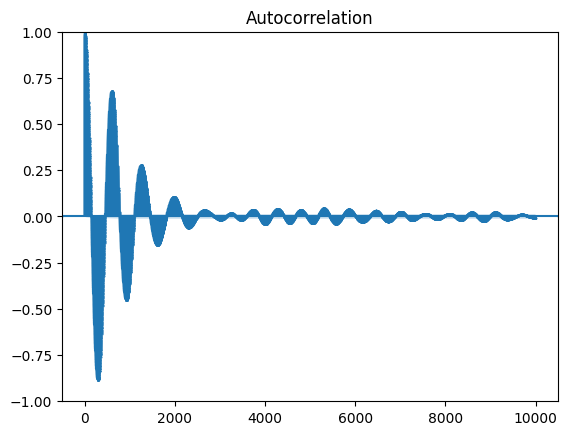

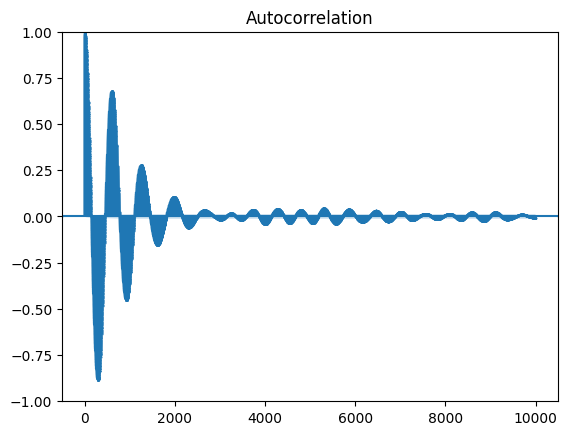

In [10]:
plot_acf(array,fft=True,lags=np.arange(10000),marker='.',markersize=1)

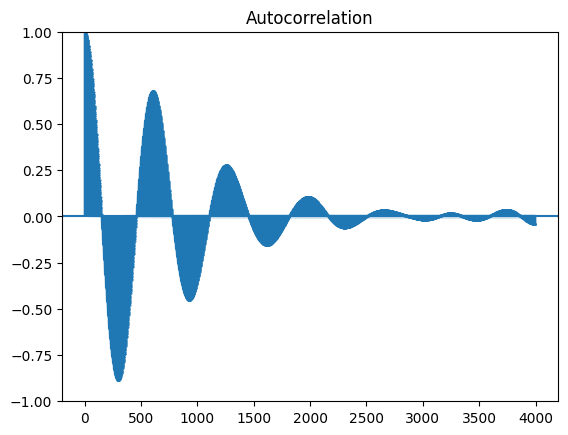

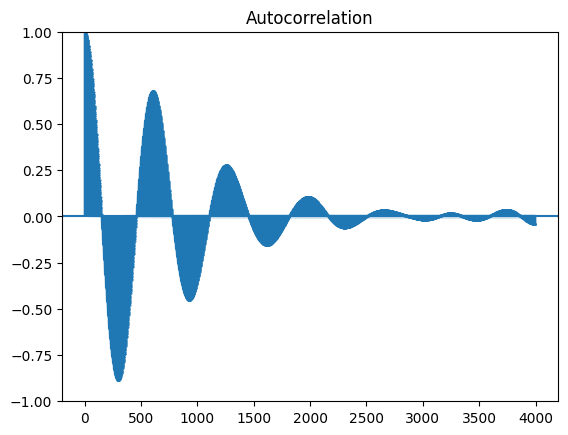

In [11]:
plot_acf(array,fft=True,lags=np.arange(4000),marker='.',markersize=1)

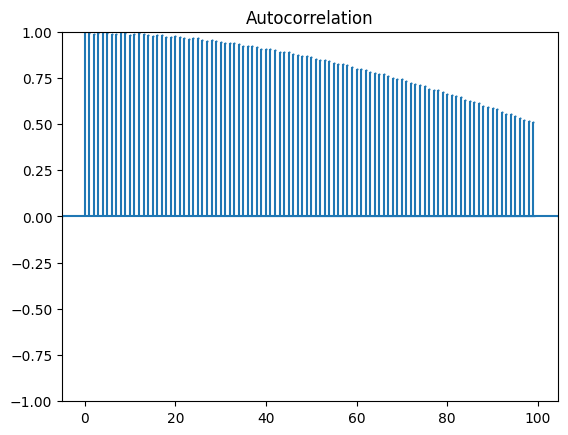

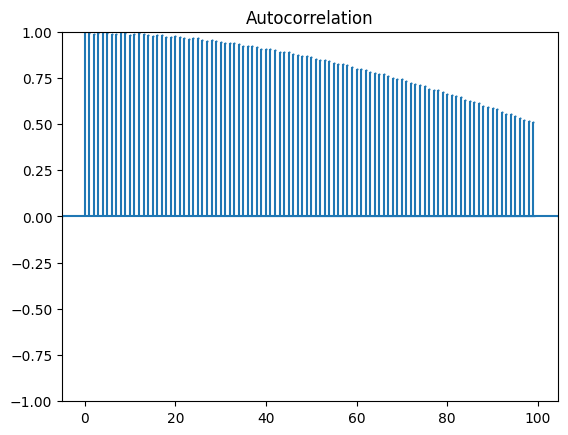

In [12]:
plot_acf(array,fft=True,lags=np.arange(100),marker='.',markersize=1)

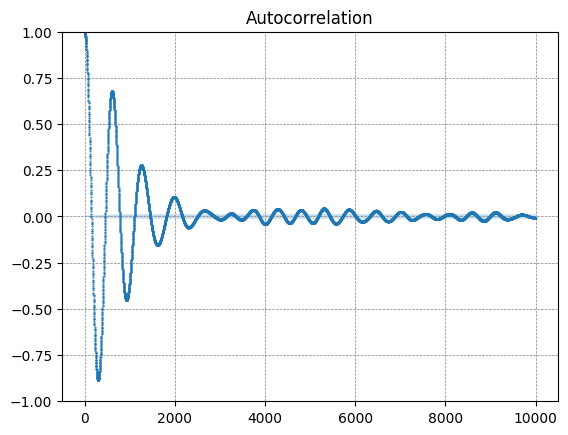

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plot_acf(array,fft=True,lags=np.arange(10000),marker='.',markersize=1,use_vlines=False,ax=ax,adjusted=True)
ax.grid(which="major", color="grey", linestyle="--", linewidth=0.5)
#ax.set_yscale('log')

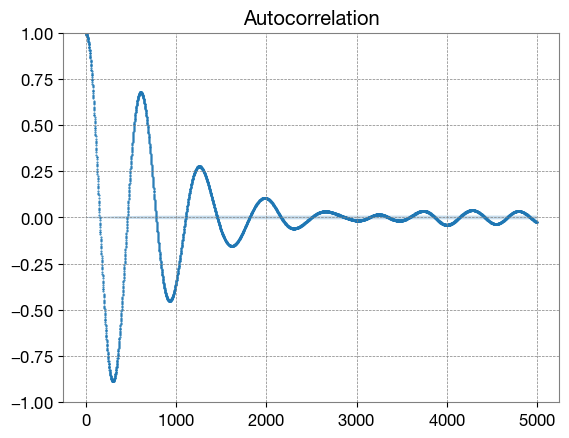

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plot_acf(array,fft=True,lags=np.arange(5000),marker='.',markersize=1,use_vlines=False,ax=ax,adjusted=True,alpha=0.1)
ax.grid(which="major", color="grey", linestyle="--", linewidth=0.5)
#ax.set_ylim(-0.05,0.05)

(-0.05, 0.05)

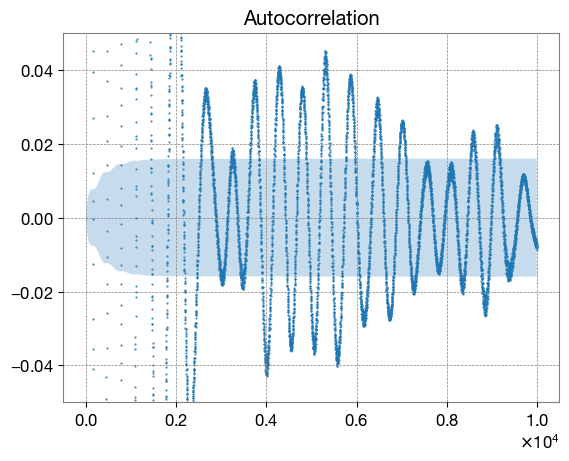

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plot_acf(array,fft=True,lags=np.arange(10000),marker='.',markersize=1,use_vlines=False,ax=ax,adjusted=True,alpha=.01)
ax.grid(which="major", color="grey", linestyle="--", linewidth=0.5)
ax.set_ylim(-0.05,0.05)

In [58]:
t1 = 1126259462.4
fs = 4096
NFFT = 4 * fs           # Use 4 seconds of data for each fourier transform
NOVL = 1 * NFFT / 2     # The number of points of overlap between segments used in Welch averaging
psd_window = scipy.signal.windows.tukey(NFFT, alpha=(1./4))


In [62]:
Pxx_H1, freqs = mlab.psd(array, Fs=fs, NFFT=NFFT,window=psd_window)

In [348]:
def plot_psd_comparison(data):

    fs = 4096
    NFFT = 4 * fs           # Use 4 seconds of data for each fourier transform
    NOVL = 1 * NFFT / 2     # The number of points of overlap between segments used in Welch averaging
    psd_window = scipy.signal.windows.tukey(NFFT, alpha=(1./4))
    psd_window_hann = scipy.signal.windows.hann(NFFT,sym=False)

    # psd using a tukey window but no welch averaging
    tukey_Pxx_H1, tukey_freqs = mlab.psd(data, Fs=fs, NFFT=NFFT, window=psd_window)
    hann_Pxx_H1, hann_freqs = mlab.psd(data, Fs=fs, NFFT=NFFT, window=psd_window_hann)
    # psd with no window, no averaging
    nowin_Pxx_H1, nowin_freqs = mlab.psd(data, Fs=fs, NFFT=NFFT, 
                                            window=mlab.window_none)
    #welch + window
    welch_tukey_freqs, welch_tukey = scipy.signal.welch(data, fs=fs, nfft=NFFT,window=psd_window)

    plt.figure(figsize=(15, 5))
    ax = plt.axes()
    # scale x and y axes
    plt.xscale('log', base=2)
    plt.yscale('log', base=10)

    # plot nowindow, tukey, welch together 
    plt.plot(nowin_freqs, nowin_Pxx_H1,'tab:green',label= 'No Window',
                     alpha=.8, linewidth=.7)
    plt.plot(hann_freqs, hann_Pxx_H1 ,'tab:orange',label='Hann Window',
                      alpha=.8, linewidth=.7)
    plt.plot(tukey_freqs, tukey_Pxx_H1,'tab:blue',label='Tukey Window', alpha=.8,
                     linewidth=.7)
    #plt.plot(welch_tukey_freqs, welch_tukey,'tab:red',label='Hann Window + Tukey Average', alpha=.8,
    #                 linewidth=.7)

    # plot 1/f^2
    # give it the right starting scale to fit with the rest of the plots
    # don't include zero frequency
    inverse_square = np.array(list(map(lambda f: 1 / (f**2), 
                                    nowin_freqs[1:])))
    # inverse starts at 1 to take out 1/0
    scale_index = 500 # chosen by eye to fit the plot
    scale = nowin_Pxx_H1[scale_index]  / inverse_square[scale_index]
    #plt.plot(nowin_freqs[1:], inverse_square * scale,'green',
    #            label= r'$1 / f^2$', alpha=.8, linewidth=1)

    plt.axis([20, 1024, 1e-47, 1e-40])
    plt.ylabel(r'S$_n$(t)')
    plt.xlabel('Freq (Hz)')
    # ax.minorticks_on()
    ax.tick_params(axis='x', which='minor', direction='out')
    # ax.minorticks_on()
    plt.legend(loc='best')
    plt.title('PSD for 4 s long segments welch averaged over the 4096 s')
    plt.savefig('psd_stretch.pdf')
    plt.show()

    acf_array = acf(tukey_Pxx_H1, fft=True, nlags=100)
    acf_nowin = acf(nowin_freqs, fft=True, nlags=100)
    print(np.where(freqs==50), np.where(freqs==512)[0])
    acf_small = acf(tukey_Pxx_H1[np.where(freqs==50)[0][0] : np.where(freqs==512)[0][0]], fft=True, nlags=100)
    plt.plot(acf_array, label='Windowed')
    plt.plot(acf_nowin, label='Leakage')
    plt.plot(acf_small, label='Windowed+Restricted')
    plt.ylabel('Normalized ACF')
    plt.xlabel('Lag')
    plt.legend(loc='best')
    plt.title('Normalized ACF for the PSD')
    plt.show()
    return 


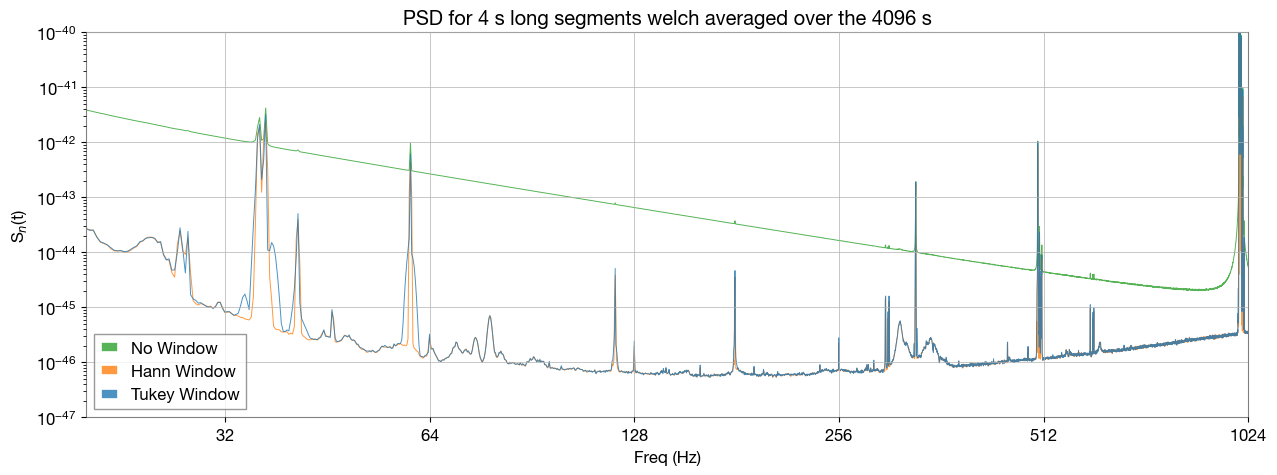

NameError: name 'freqs' is not defined

In [349]:
plot_psd_comparison(array)

In [350]:
t0=1126257415

In [351]:
strain_cbc = pycbc.types.timeseries.TimeSeries(array, delta_t=1/4096, epoch=t0)
strain_passed = highpass(strain_cbc, 15.0)
# strain = resample_to_delta_t(strain, 1.0/2048)
conditioned = strain_passed.crop(2, 2)

In [37]:
conditioned

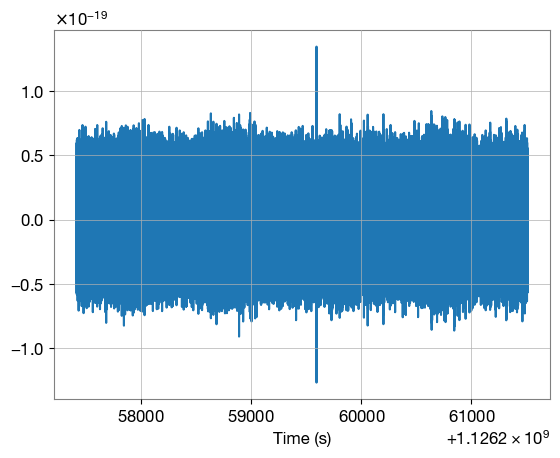

In [36]:
plt.plot(conditioned.sample_times, conditioned)
plt.xlabel('Time (s)')
plt.show()

In [353]:
# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4,window='hann')

	# Now that we have the psd we need to interpolate it to match our data
	# and then limit the filter length of 1 / PSD. After this, we can
	# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

	# 1/PSD will now act as a filter with an effective length of 4 seconds
	# Since the data has been highpassed above 15 Hz, and will have low values
	# below this we need to inform the function to not include frequencies
	# below this frequency. 
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),low_frequency_cutoff=15)


(16, 1024)

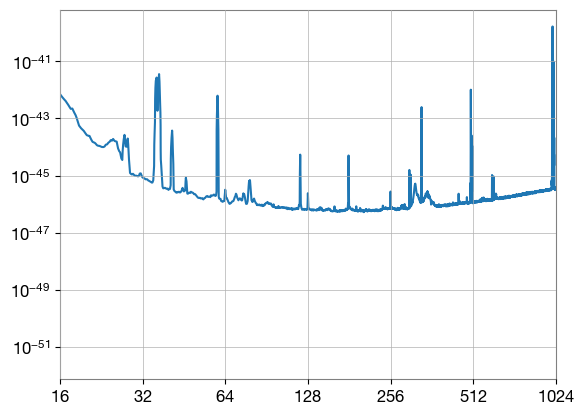

In [48]:
plt.plot(psd.sample_frequencies,psd)
plt.yscale('log')
plt.xscale('log',base=2)
plt.xlim(16,1024)

In [12]:
M_chirp = np.linspace(25, stop=35, num=100)
q = np.linspace(0.5, stop=1, num=10)
m1 = np.linspace(10, stop=40, num=30)
m2 = np.linspace(10, stop=40, num=30)
Masses = []
peaks = []
times = []
templates = []
m = 36 # Solar masses
for i in M_chirp:
    for j in q:
			# Get a frequency domain waveform
#M_chirp = 29.3
#q = 1
	
        sptilde, sctilde = get_fd_waveform(approximant="TaylorF2",
							 mass1=mass1_from_mchirp_q(i, j), 
							 mass2=mass2_from_mchirp_q(i, j),
							 delta_f=1.0/4, 
							 f_lower=20)

			# FFT it to the time-domain
        delta_t = 1/4096
        tlen = int(1.0 / delta_t / sptilde.delta_f)
        sptilde.resize(tlen/2 + 1)
        sp = pycbc.types.timeseries.TimeSeries(types.zeros(tlen), delta_t=delta_t)
        fft.ifft(sptilde, sp)

			# Resize the vector to match our data
        sp.resize(len(conditioned))
        template = sp.cyclic_time_shift(sp.start_time)
        #templates.append(template)
			# print("starting")
        snr = matched_filter(template, conditioned,
					 psd=psd, low_frequency_cutoff=20)

	# Remove time corrupted by the template filter and the psd filter
	# We remove 4 seonds at the beginning and end for the PSD filtering
	# And we remove 4 additional seconds at the beginning to account for
	# the template length (this is somewhat generous for 
	# so short a template). A longer signal such as from a BNS, would 
	# require much more padding at the beginning of the vector.
        snr = snr.crop(4 + 4, 4)

	# Why are we taking an abs() here?
	# The `matched_filter` function actually returns a 'complex' SNR.
	# What that means is that the real portion correponds to the SNR
	# associated with directly filtering the template with the data.
	# The imaginary portion corresponds to filtering with a template that
	# is 90 degrees out of phase. Since the phase of a signal may be 
	# anything, we choose to maximize over the phase of the signal.
	
	# pylab.figure(figsize=[10, 4])
        peak = abs(snr).numpy().argmax()
        time = snr.sample_times[peak]
        times.append(time)
#plt.plot(snr.sample_times, abs(snr))
#plt.title('The SNR computed for the full timeseries')
#plt.ylabel('Signal-to-noise')
#plt.xlabel('Time (s)')
#plt.show()

Text(0.5, 1.0, 'Histogram of SNR peak times')

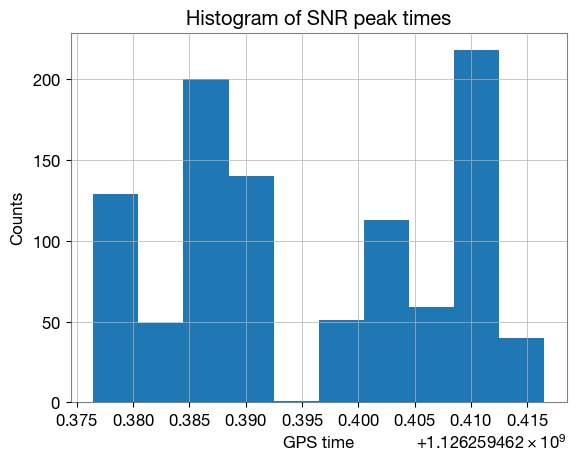

In [19]:
plt.hist(times)
plt.xlabel('GPS time')
plt.ylabel('Counts')
plt.title('Histogram of SNR peak times')

In [91]:
from mpl_toolkits import mplot3d

In [287]:
def f(x, y):
    #return abs((x**8 * (1 + y)**8 * (x**2 * (1 - 24 * y) + 25 * (1 + y)**2)) / (0.0001*y))
    return x*(1+y)**(2/5)/(1079.24*y**(6/5))
x = np.linspace(9, 35, 100)
y = np.linspace(0.25, 1, 100)

X, Y = np.meshgrid(x, y)
g = f(X, Y)

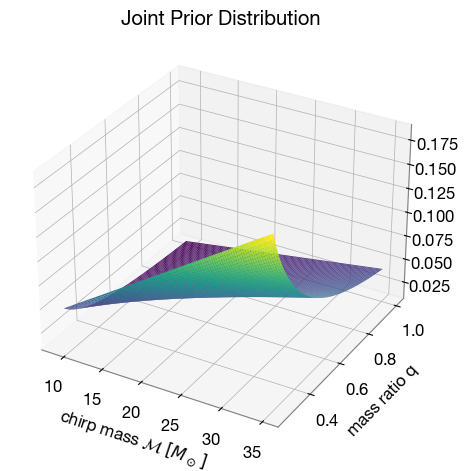

In [298]:
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, g, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Joint Prior Distribution')
ax.set_xlabel('chirp mass $\mathcal{M}$ $[M_\odot]$')
ax.set_ylabel('mass ratio q')
#ax.set_zlabel('p()')
plt.tight_layout()

Text(0, 0.5, 'mass ratio q')

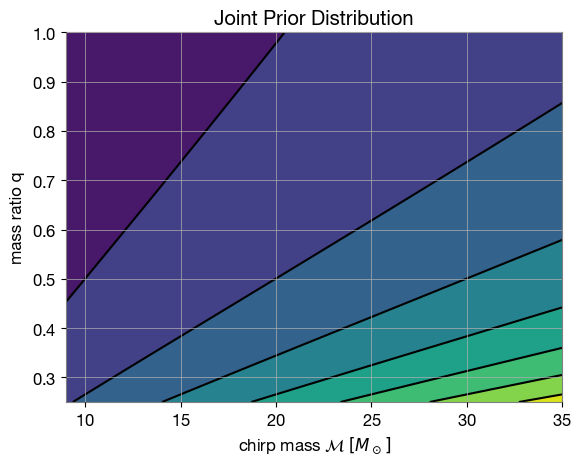

In [300]:
fig, axs = plt.subplots(ncols=1)
cs = axs.contourf(X, Y, g)
axs.contour(cs, colors='k')
axs.set_title('Joint Prior Distribution')
axs.set_xlabel('chirp mass $\mathcal{M}$ $[M_\odot]$')
axs.set_ylabel('mass ratio q')

In [304]:
def prior_m(x):
    return x/572#1.88678
def prior_q(x,a,b,c,d):
    N=0.53000715006729471#((b*d)**(6/5)/(b+d)**(2/5)-(a*c)**(6/5)/(a+c)**(2/5))/2
    return  N*((1+x)**(2/5))/(x**(6/5))/1.8867845398534149

In [181]:
b=10
d=10
(b*d)**(3/5)/(b+d)**(1/5)

8.705505632961241

In [197]:
import scipy.integrate as integrate

Text(0, 0.5, 'p(q|I)')

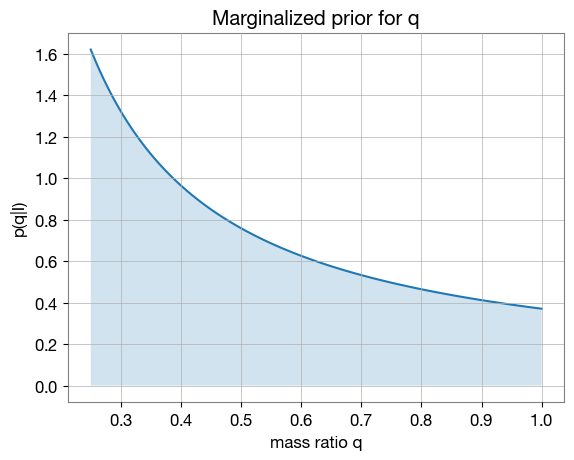

In [303]:
linspace_m = np.linspace(9,35,100, dtype=float)
linspace_q = np.linspace(0.25,1,100, dtype=float)
plt.plot(linspace_q,prior_q(linspace_q,10,40,10,40))
plt.fill_between(linspace_q,prior_q(linspace_q,10,40,10,40),alpha=0.2)
plt.title('Marginalized prior for q')
plt.xlabel('mass ratio q')
plt.ylabel('p(q|I)')

In [305]:
integrate.quad(prior_q,0.25,1,args=(10,40,10,40))

(0.5300071500672948, 4.7136787307608583e-11)

Text(0, 0.5, 'p($\\mathcal{M}$|I)')

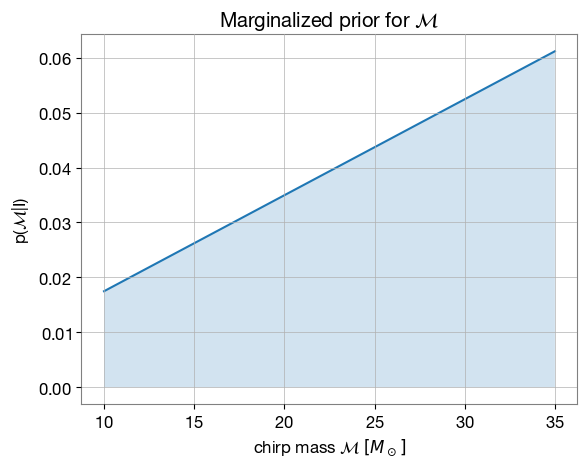

In [306]:
plt.plot(linspace_m,prior_m(linspace_m))
plt.fill_between(linspace_m,prior_m(linspace_m),alpha=0.2)
plt.title('Marginalized prior for $\mathcal{M}$')
plt.xlabel('chirp mass $\mathcal{M}$ $[M_\odot]$')
plt.ylabel('p($\mathcal{M}$|I)')

In [418]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.gw.prior import UniformInComponentsChirpMass, UniformInComponentsMassRatio
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries
t0 = 1126257415
time_of_event = 1126259462.4 
data = array
strain = TimeSeries(data, t0=t0, sample_rate=4096, unit='strain')

H1 = bilby.gw.detector.get_empty_interferometer("H1")

    # Definite times in relatation to the trigger time (time_of_event), duration and post_trigger_duration
post_trigger_duration = 2
duration = 4
analysis_start = time_of_event + post_trigger_duration - duration

H1_analysis_data = strain.crop(analysis_start , analysis_start+duration)

    # H1_analysis_data.plot()
    # plt.show()
#from gwpy.signal import filter_design
#bp = filter_design.bandpass(50, 250, H1_analysis_data.sample_rate)
#notches = [filter_design.notch(line, H1_analysis_data.sample_rate) for
#           line in (60, 120, 180)]
#zpk = filter_design.concatenate_zpks(bp, *notches)
#hfilt = H1_analysis_data.filter(zpk, filtfilt=True)
#hfilt = hfilt.crop(*hfilt.span.contract(1))


H1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)

psd_duration = duration * 32
psd_start_time = analysis_start - psd_duration

H1_psd_data = strain.crop(psd_start_time , psd_start_time+psd_duration)

#from gwpy.signal import filter_design
#bp = filter_design.bandpass(50, 250, H1_psd_data.sample_rate)
#notches = [filter_design.notch(line, H1_psd_data.sample_rate) for
#           line in (60, 120, 180)]
#zpk = filter_design.concatenate_zpks(bp, *notches)
#hfilt_psd = H1_psd_data.filter(zpk, filtfilt=True)
#hfilt_psd = hfilt_psd.crop(*hfilt_psd.span.contract(1))

psd_alpha = 2 * H1.strain_data.roll_off / duration
H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")

H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
        frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)

H1.maximum_frequency = 1024

injection_parameters = dict(
    chirp_mass=28.09,
    mass_ratio=0.8,
    a_1=0.,
    a_2=0.,
    tilt_1=0.,#0.5
    tilt_2=0.0, #1.0
    phi_12=1.7,
    phi_jl=0.3,
    luminosity_distance=1000.0,
    theta_jn=0.4,
    phase=1.3,
    ra=1.375,
    dec=1.12108,
    geocent_time=time_of_event,
    psi=2.659,
)
# first, set up all priors to be equal to a delta function at their designated value
#prior = bilby.gw.prior.BBHPriorDict(injection_parameters.copy())
# then, reset the priors on the masses and luminosity distance to conduct a search over these parameters
#prior['chirp_mass'] = bilby.gw.prior.UniformInComponentsChirpMass(name='chirp_mass', minimum=8.0,maximum=35.0)
#prior['mass_ratio'] = bilby.gw.prior.UniformInComponentsMassRatio(name='mass_ratio', minimum=0.5, maximum=1)
#prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-1, maximum=time_of_event+1)
#prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
#prior["luminosity_distance"] = bilby.core.prior.Uniform(200, 2000, "luminosity_distance")


prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = UniformInComponentsChirpMass(name='chirp_mass', minimum=8.0,maximum=35.0)
prior['mass_ratio'] = UniformInComponentsMassRatio(name='mass_ratio', minimum=0.25, maximum=1)
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.1, maximum=time_of_event+0.1)
#prior['phase'] = 1.3
prior['a_1'] =  0.
prior['a_2'] =  0.
prior['tilt_1'] =  0.
prior['tilt_2'] =  0.
prior['phi_12'] =  0.
prior['phi_jl'] =  0.
prior['dec'] =  -1.2232
prior['ra'] =   2.19432
prior['theta_jn'] =  1.89694
prior['psi'] = 0.532268
prior['luminosity_distance'] = 412.066

# First, put our "data" created above into a list of intererometers (only H1)
interferometers = [H1]

# Next create a dictionary of arguments which we pass into the LALSimulation waveform - we specify the waveform approximant here
waveform_arguments = dict(
        waveform_approximant='TaylorF2', reference_frequency=50.) #, catch_waveform_errors=True)

# Next, create a waveform_generator object. This wraps up some of the jobs of converting between parameters etc
waveform_generator = bilby.gw.WaveformGenerator(
        duration=duration, sampling_frequency=4096.,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        waveform_arguments=waveform_arguments,
        parameter_conversion=convert_to_lal_binary_black_hole_parameters)

# Finally, create our likelihood, passing in what is needed to get going
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
        interferometers, waveform_generator, priors=prior,
        time_marginalization=True, phase_marginalization=True, distance_marginalization=False)

13:30 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [419]:
result = bilby.run_sampler(
        likelihood, prior, sampler='dynesty', outdir='proooova', label="GW150914_distance_boh",
        conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
        nlive = 100, dlogz=0.1
        )

13:30 bilby INFO    : Running for label 'GW150914_distance_boh', output will be saved to 'proooova'
13:30 bilby INFO    : Using lal version 7.3.1
13:30 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.19;Id: 84d780c102cf51ea1fdf7a1cbf0a626a5eca0d0a;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed
13:30 bilby INFO    : Using lalsimulation version 5.2.1
13:30 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.19;Id: 84d780c102cf51ea1fdf7a1cbf0a626a5eca0d0a;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
13:30 bilby INFO    : Analysis priors:
13:30 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpMass(minimum=8.0, maximum=35.0, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boun

358it [01:03,  1.22it/s, bound:0 nc: 73 ncall:3.4e+03 eff:10.6% logz-ratio=86.92+/-0.20 dlogz:10.757>0.1] 

/usr/local/lib/python3.10/site-packages/dynesty/sampler.py:756: UserWarning: The sampling was stopped short due to maxiter/maxcall limit the delta(log(z)) criterion is not achieved; posterior may be poorly sampled
  warnings.warn('The sampling was stopped short due to'


803it [09:56,  1.24s/it, bound:37 nc:  1 ncall:2.7e+04 eff:3.3% logz-ratio=95.62+/-0.20 dlogz:0.026>0.1] 

13:40 bilby INFO    : Written checkpoint file proooova/GW150914_distance_boh_resume.pickle


803it [10:02,  1.33it/s, bound:37 nc:  1 ncall:2.7e+04 eff:3.4% logz-ratio=95.64+/-0.21 dlogz:0.001>0.1]

13:40 bilby INFO    : Rejection sampling nested samples to obtain 206 posterior samples
13:40 bilby INFO    : Sampling time: 0:10:02.415178
13:40 bilby INFO    : Computing per-detector log likelihoods.




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:04<00:00, 47.93it/s]

13:40 bilby INFO    : Reconstructing marginalised parameters.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:07<00:00, 28.48it/s]

13:40 bilby INFO    : Generating sky frame parameters.



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:00<00:00, 2258.72it/s]

13:40 bilby INFO    : Computing SNRs for every sample.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:04<00:00, 49.12it/s]


13:41 bilby INFO    : Summary of results:
nsamples: 206
ln_noise_evidence: -4386.975
ln_evidence: -4291.337 +/-  0.249
ln_bayes_factor: 95.638 +/-  0.249



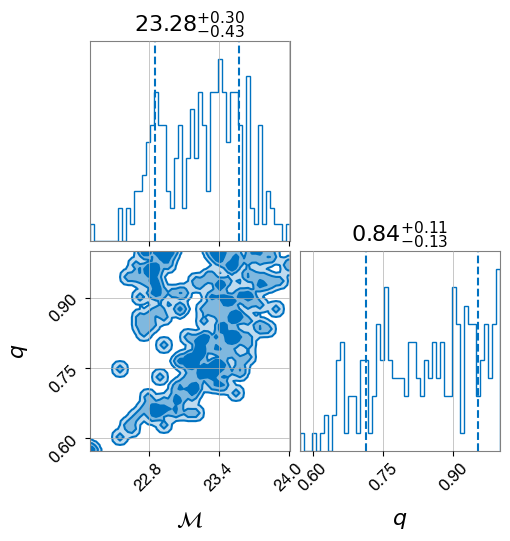

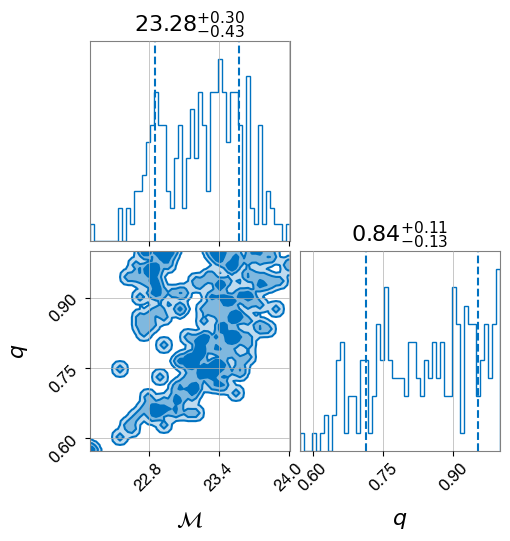

In [420]:
result.plot_corner(parameters=["chirp_mass", "mass_ratio"], prior=True, save=False)

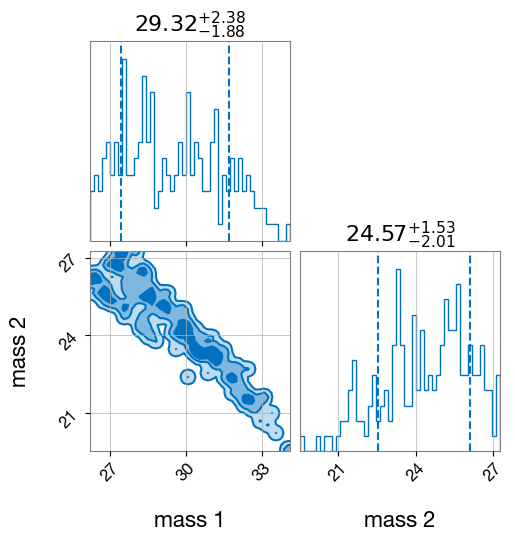

In [421]:
parameters = dict(mass_1=36.2, mass_2=29.1)
fig = result.plot_corner(parameters,save=False)

14:57 bilby INFO    : Generating waveform figure for H1
14:57 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


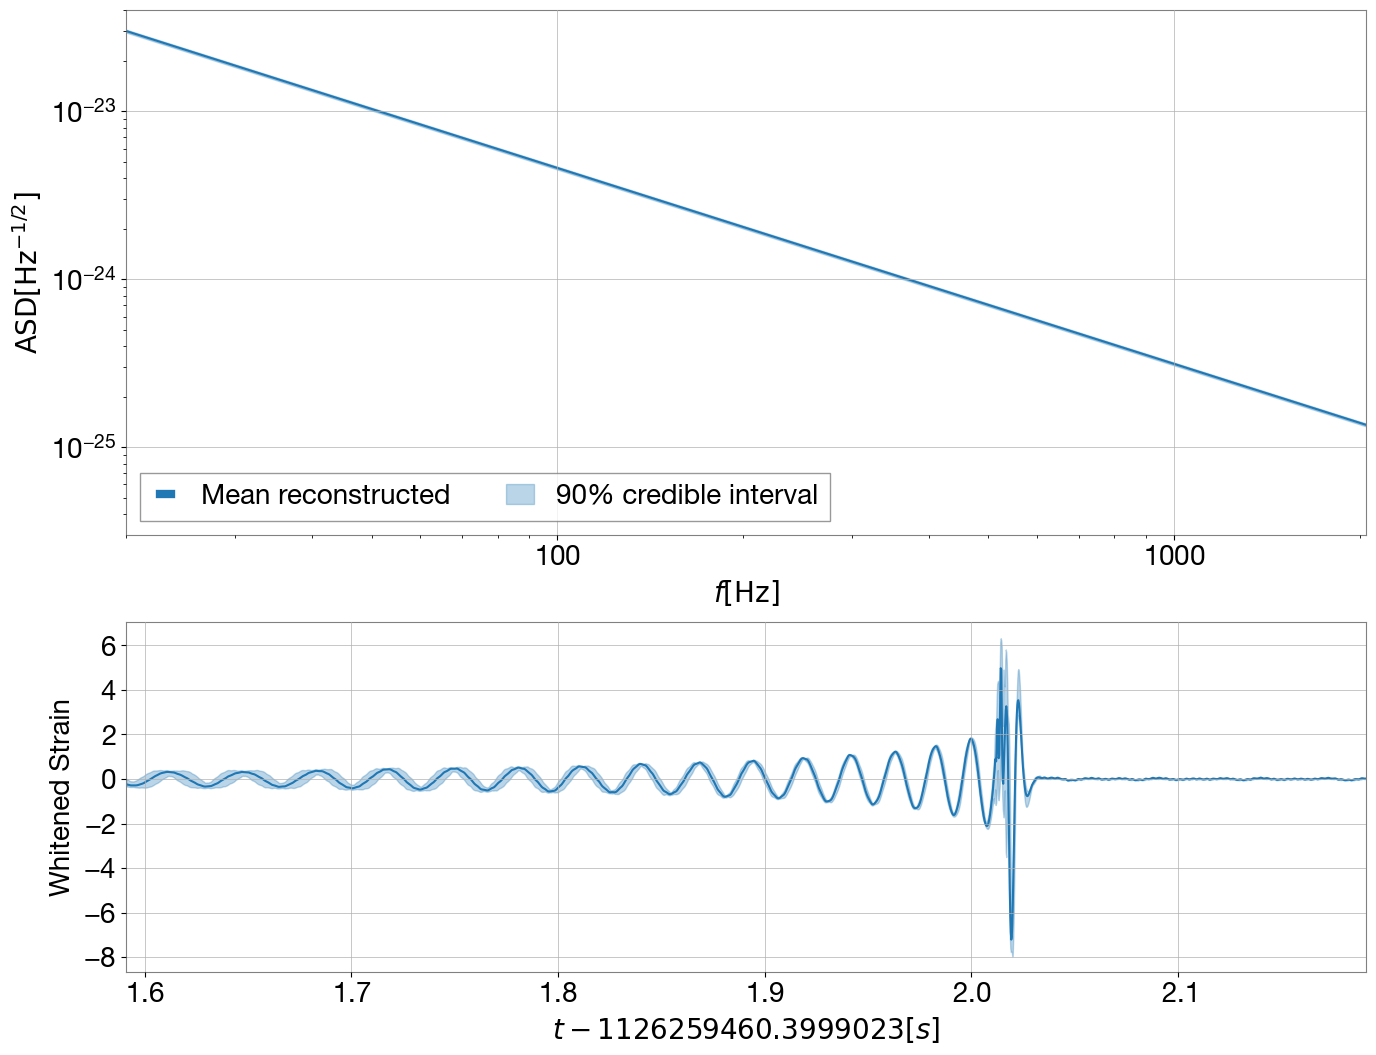

In [310]:
from bilby.gw.result import CBCResult

cbc_result = CBCResult.from_json("nlive/GW150914_result.json")
cbc_result.plot_interferometer_waveform_posterior(n_samples=500, save=False,interferometer='H1'
    )
plt.show()
plt.close()


In [315]:
hp, hc = get_td_waveform(approximant="TaylorF2",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# We will resize the vector to match our data
hp.resize(len(conditioned))

In [237]:
# Next create a dictionary of arguments which we pass into the LALSimulation waveform - we specify the waveform approximant here
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                          reference_frequency=50., minimum_frequency=20.)

result_accurate_model = bilby.run_sampler(
        likelihood, prior, sampler='dynesty', outdir='accurate_model', label="GW150914",
        conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
        nlive = 1000, dlogz=0.1
        )

12:01 bilby INFO    : Running for label 'GW150914', output will be saved to 'accurate_model'
12:01 bilby INFO    : Using lal version 7.3.1
12:01 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.19;Id: 84d780c102cf51ea1fdf7a1cbf0a626a5eca0d0a;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed
12:01 bilby INFO    : Using lalsimulation version 5.2.1
12:01 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.19;Id: 84d780c102cf51ea1fdf7a1cbf0a626a5eca0d0a;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
12:01 bilby INFO    : Analysis priors:
12:01 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpMass(minimum=8.0, maximum=35.0, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=No

1621it [01:16, 20.78it/s, bound:0 nc:  1 ncall:5.1e+03 eff:31.5% logz-ratio=68.61+/-0.06 dlogz:30.646>0.1] 

/usr/local/lib/python3.10/site-packages/dynesty/sampler.py:756: UserWarning: The sampling was stopped short due to maxiter/maxcall limit the delta(log(z)) criterion is not achieved; posterior may be poorly sampled
  warnings.warn('The sampling was stopped short due to'


3707it [10:01,  5.21it/s, bound:5 nc:  1 ncall:3.9e+04 eff:10.4% logz-ratio=91.56+/-0.07 dlogz:5.567>0.1] 

12:11 bilby INFO    : Written checkpoint file accurate_model/GW150914_resume.pickle


3898it [11:19,  4.09it/s, bound:12 nc:  1 ncall:4.3e+04 eff:10.1% logz-ratio=93.27+/-0.07 dlogz:3.514>0.1]

/usr/local/lib/python3.10/site-packages/dynesty/sampler.py:756: UserWarning: The sampling was stopped short due to maxiter/maxcall limit the delta(log(z)) criterion is not achieved; posterior may be poorly sampled
  warnings.warn('The sampling was stopped short due to'


5398it [21:24,  1.62it/s, bound:73 nc:  1 ncall:8.1e+04 eff:8.0% logz-ratio=95.74+/-0.10 dlogz:0.001>0.1] 

12:23 bilby INFO    : Written checkpoint file accurate_model/GW150914_resume.pickle


5523it [22:42,  2.11it/s, bound:80 nc:  1 ncall:8.5e+04 eff:7.0% logz-ratio=95.34+/-0.05 dlogz:0.629>0.1]

/usr/local/lib/python3.10/site-packages/dynesty/sampler.py:756: UserWarning: The sampling was stopped short due to maxiter/maxcall limit the delta(log(z)) criterion is not achieved; posterior may be poorly sampled
  warnings.warn('The sampling was stopped short due to'


6349it [32:01,  1.14it/s, bound:140 nc:  1 ncall:1.2e+05 eff:5.6% logz-ratio=95.59+/-0.06 dlogz:0.237>0.1]

12:33 bilby INFO    : Written checkpoint file accurate_model/GW150914_resume.pickle


7095it [42:45,  1.07s/it, bound:212 nc:  1 ncall:1.7e+05 eff:4.8% logz-ratio=95.74+/-0.07 dlogz:0.000>0.1]

12:44 bilby INFO    : Written checkpoint file accurate_model/GW150914_resume.pickle


7733it [53:16,  1.21it/s, bound:292 nc: 71 ncall:2.2e+05 eff:3.5% logz-ratio=95.66+/-0.06 dlogz:0.116>0.1]

12:54 bilby INFO    : Written checkpoint file accurate_model/GW150914_resume.pickle


7890it [59:06,  2.88s/it, bound:324 nc:  1 ncall:2.4e+05 eff:3.7% logz-ratio=95.74+/-0.07 dlogz:0.000>0.1]

13:00 bilby INFO    : Written checkpoint file accurate_model/GW150914_resume.pickle


7890it [59:13,  2.22it/s, bound:324 nc:  1 ncall:2.4e+05 eff:3.7% logz-ratio=95.74+/-0.07 dlogz:0.000>0.1]



13:00 bilby INFO    : Rejection sampling nested samples to obtain 2387 posterior samples
13:00 bilby INFO    : Sampling time: 0:59:13.759218
13:00 bilby INFO    : Computing per-detector log likelihoods.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2387/2387 [00:35<00:00, 67.89it/s]

13:01 bilby INFO    : Reconstructing marginalised parameters.



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2387/2387 [01:12<00:00, 32.81it/s]

13:02 bilby INFO    : Generating sky frame parameters.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2387/2387 [00:00<00:00, 2606.41it/s]


13:02 bilby INFO    : Computing SNRs for every sample.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2387/2387 [00:34<00:00, 69.87it/s]


13:03 bilby INFO    : Summary of results:
nsamples: 2387
ln_noise_evidence: -4386.975
ln_evidence: -4291.236 +/-  0.085
ln_bayes_factor: 95.740 +/-  0.085



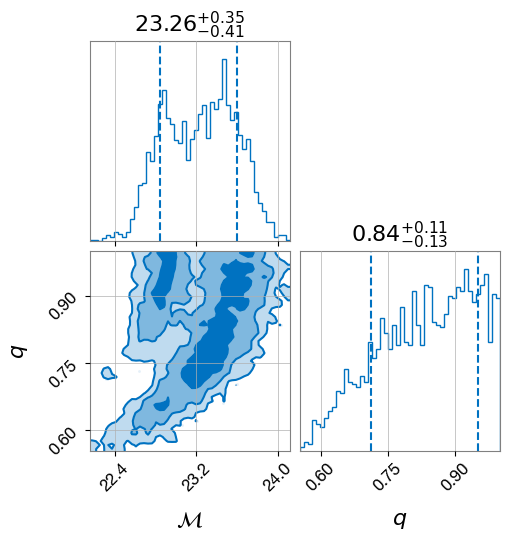

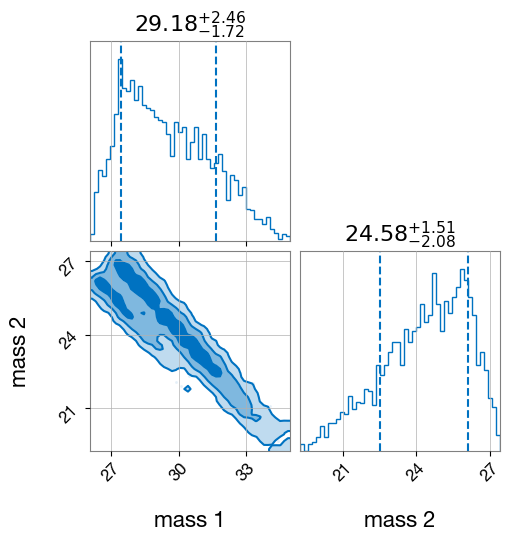

In [372]:
result_accurate_model.plot_corner(parameters=["chirp_mass", "mass_ratio"], prior=True, save=False)
parameters = dict(mass_1=36.2, mass_2=29.1)
fig = result_accurate_model.plot_corner(parameters, save=False)
plt.show()

In [285]:
result_def = bilby.run_sampler(
        likelihood, prior, sampler='dynesty', outdir='prova', label="GW150914",
        conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
        #injection_parameter=injection_parameters,
        npoints = 100, dlogz=0.1
        )

18:32 bilby INFO    : Running for label 'GW150914', output will be saved to 'prova'
18:32 bilby INFO    : Using lal version 7.3.1
18:32 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.19;Id: 84d780c102cf51ea1fdf7a1cbf0a626a5eca0d0a;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed
18:32 bilby INFO    : Using lalsimulation version 5.2.1
18:32 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.19;Id: 84d780c102cf51ea1fdf7a1cbf0a626a5eca0d0a;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
18:32 bilby INFO    : Analysis priors:
18:32 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpMass(minimum=8.0, maximum=35.0, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
18:32


1it [00:00, ?it/s]
5it [00:00, 39.00it/s, bound:0 nc:  1 ncall:1.0e+02 eff:4.8% logz-ratio=-201.80+/-0.22 dlogz:269.813>0.1]
11it [00:00, 50.30it/s, bound:0 nc:  1 ncall:1.1e+02 eff:9.9% logz-ratio=-187.16+/-0.21 dlogz:254.516>0.1]
17it [00:00, 49.97it/s, bound:0 nc:  1 ncall:1.2e+02 eff:14.4% logz-ratio=-177.32+/-0.22 dlogz:245.208>0.1]
23it [00:00, 51.04it/s, bound:0 nc:  1 ncall:1.2e+02 eff:18.4% logz-ratio=-163.40+/-0.21 dlogz:230.016>0.1]
29it [00:00, 49.26it/s, bound:0 nc:  1 ncall:1.3e+02 eff:21.8% logz-ratio=-147.14+/-0.21 dlogz:213.769>0.1]
34it [00:00, 46.75it/s, bound:0 nc:  1 ncall:1.4e+02 eff:24.3% logz-ratio=-131.18+/-0.23 dlogz:201.205>0.1]
39it [00:00, 45.81it/s, bound:0 nc:  1 ncall:1.5e+02 eff:26.7% logz-ratio=-119.76+/-0.21 dlogz:186.226>0.1]
44it [00:00, 39.14it/s, bound:0 nc:  1 ncall:1.6e+02 eff:28.2% logz-ratio=-106.46+/-0.21 dlogz:173.052>0.1]
49it [00:01, 39.62it/s, bound:0 nc:  1 ncall:1.6e+02 eff:30.2% logz-ratio=-95.28+/-0.22 dlogz:162.706>0.1] 
54it [00:01

219it [00:14,  7.93it/s, bound:0 nc: 10 ncall:9.2e+02 eff:23.8% logz-ratio=35.07+/-0.20 dlogz:40.003>0.1]
221it [00:14,  8.57it/s, bound:0 nc:  4 ncall:9.3e+02 eff:23.7% logz-ratio=35.60+/-0.20 dlogz:39.549>0.1]
223it [00:14,  8.52it/s, bound:0 nc:  7 ncall:9.5e+02 eff:23.5% logz-ratio=36.01+/-0.20 dlogz:39.028>0.1]
225it [00:14,  9.34it/s, bound:0 nc:  2 ncall:9.6e+02 eff:23.5% logz-ratio=36.36+/-0.20 dlogz:38.641>0.1]
227it [00:15,  7.32it/s, bound:0 nc: 12 ncall:9.9e+02 eff:23.0% logz-ratio=36.71+/-0.20 dlogz:38.282>0.1]
229it [00:15,  8.86it/s, bound:0 nc:  4 ncall:9.9e+02 eff:23.1% logz-ratio=37.05+/-0.20 dlogz:37.912>0.1]
231it [00:15,  8.92it/s, bound:0 nc:  1 ncall:1.0e+03 eff:23.0% logz-ratio=37.41+/-0.20 dlogz:37.546>0.1]
233it [00:15,  7.73it/s, bound:0 nc: 22 ncall:1.0e+03 eff:22.6% logz-ratio=37.76+/-0.20 dlogz:37.153>0.1]
236it [00:15,  9.76it/s, bound:0 nc:  6 ncall:1.0e+03 eff:22.7% logz-ratio=38.27+/-0.20 dlogz:36.633>0.1]
238it [00:16, 10.24it/s, bound:0 nc:  5 ncall:

320it [00:38,  2.98it/s, bound:0 nc: 35 ncall:2.5e+03 eff:12.9% logz-ratio=52.33+/-0.21 dlogz:26.299>0.1]
321it [00:39,  1.78it/s, bound:0 nc: 81 ncall:2.6e+03 eff:12.5% logz-ratio=52.44+/-0.21 dlogz:26.183>0.1]
322it [00:40,  1.93it/s, bound:0 nc: 32 ncall:2.6e+03 eff:12.4% logz-ratio=52.54+/-0.21 dlogz:26.065>0.1]
323it [00:40,  2.07it/s, bound:0 nc: 25 ncall:2.6e+03 eff:12.3% logz-ratio=52.63+/-0.21 dlogz:25.957>0.1]
324it [00:41,  1.84it/s, bound:0 nc: 48 ncall:2.7e+03 eff:12.1% logz-ratio=52.71+/-0.21 dlogz:25.857>0.1]
325it [00:42,  1.52it/s, bound:0 nc: 67 ncall:2.7e+03 eff:11.9% logz-ratio=52.80+/-0.21 dlogz:25.760>0.1]
326it [00:42,  1.57it/s, bound:0 nc: 42 ncall:2.8e+03 eff:11.7% logz-ratio=52.88+/-0.21 dlogz:25.666>0.1]
327it [00:42,  1.80it/s, bound:0 nc: 24 ncall:2.8e+03 eff:11.7% logz-ratio=52.96+/-0.21 dlogz:25.575>0.1]
328it [00:43,  2.12it/s, bound:0 nc: 19 ncall:2.8e+03 eff:11.6% logz-ratio=53.04+/-0.21 dlogz:25.486>0.1]
329it [00:43,  2.10it/s, bound:0 nc: 30 ncall:

/usr/local/lib/python3.10/site-packages/dynesty/sampler.py:756: UserWarning: The sampling was stopped short due to maxiter/maxcall limit the delta(log(z)) criterion is not achieved; posterior may be poorly sampled
  warnings.warn('The sampling was stopped short due to'



378it [01:35,  1.59s/it, bound:2 nc: 89 ncall:4.6e+03 eff:8.2% logz-ratio=59.10+/-0.19 dlogz:19.874>0.1]
400it [02:07,  1.51s/it, bound:5 nc:101 ncall:6.6e+03 eff:6.1% logz-ratio=60.51+/-0.21 dlogz:18.227>0.1]
419it [02:32,  1.43s/it, bound:8 nc: 71 ncall:8.5e+03 eff:4.9% logz-ratio=61.80+/-0.15 dlogz:16.777>0.1]
439it [03:04,  1.50s/it, bound:11 nc: 71 ncall:9.9e+03 eff:4.4% logz-ratio=63.17+/-0.21 dlogz:15.820>0.1]
460it [03:42,  1.61s/it, bound:14 nc:126 ncall:1.2e+04 eff:3.9% logz-ratio=64.67+/-0.11 dlogz:14.121>0.1]
481it [04:04,  1.41s/it, bound:18 nc: 70 ncall:1.5e+04 eff:3.3% logz-ratio=65.75+/-0.20 dlogz:12.812>0.1]
502it [04:31,  1.38s/it, bound:20 nc: 70 ncall:1.6e+04 eff:3.1% logz-ratio=66.77+/-0.15 dlogz:11.585>0.1]
523it [05:04,  1.44s/it, bound:23 nc: 90 ncall:1.8e+04 eff:2.9% logz-ratio=67.69+/-0.20 dlogz:10.448>0.1]
547it [07:14,  2.80s/it, bound:27 nc:109 ncall:2.1e+04 eff:2.7% logz-ratio=68.46+/-0.13 dlogz:10.869>0.1]
567it [07:20,  2.09s/it, bound:37 nc:408 ncall:2

18:43 bilby INFO    : Written checkpoint file prova/GW150914_resume.pickle



1057it [10:37,  2.45it/s, bound:59 nc: 31 ncall:4.2e+04 eff:2.5% logz-ratio=75.95+/-0.25 dlogz:0.191>0.1]
1060it [10:52,  1.47it/s, bound:59 nc: 31 ncall:4.2e+04 eff:2.5% logz-ratio=75.95+/-0.25 dlogz:0.185>0.1]
1084it [11:08,  1.48it/s, bound:61 nc: 47 ncall:4.3e+04 eff:2.5% logz-ratio=75.98+/-0.25 dlogz:0.144>0.1]
1107it [11:19,  1.64it/s, bound:63 nc: 37 ncall:4.5e+04 eff:2.5% logz-ratio=76.01+/-0.25 dlogz:0.114>0.1]

18:44 bilby INFO    : Written checkpoint file prova/GW150914_resume.pickle


1119it [11:24,  1.63it/s, bound:64 nc:  1 ncall:4.5e+04 eff:2.7% logz-ratio=76.10+/-0.26 dlogz:0.001>0.1]

18:44 bilby INFO    : Rejection sampling nested samples to obtain 332 posterior samples
18:44 bilby INFO    : Sampling time: 0:11:24.836798
18:44 bilby INFO    : Computing per-detector log likelihoods.





100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 332/332 [00:04<00:00, 66.80it/s]

18:44 bilby INFO    : Reconstructing marginalised parameters.




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 332/332 [00:08<00:00, 41.38it/s]

18:44 bilby INFO    : Generating sky frame parameters.




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 332/332 [00:00<00:00, 2557.21it/s]

18:44 bilby INFO    : Computing SNRs for every sample.




 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 263/332 [00:04<00:01, 56.72it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 332/332 [00:06<00:00, 53.53it/s]


18:44 bilby INFO    : Summary of results:
nsamples: 332
ln_noise_evidence: -4386.975
ln_evidence: -4310.871 +/-  0.319
ln_bayes_factor: 76.104 +/-  0.319



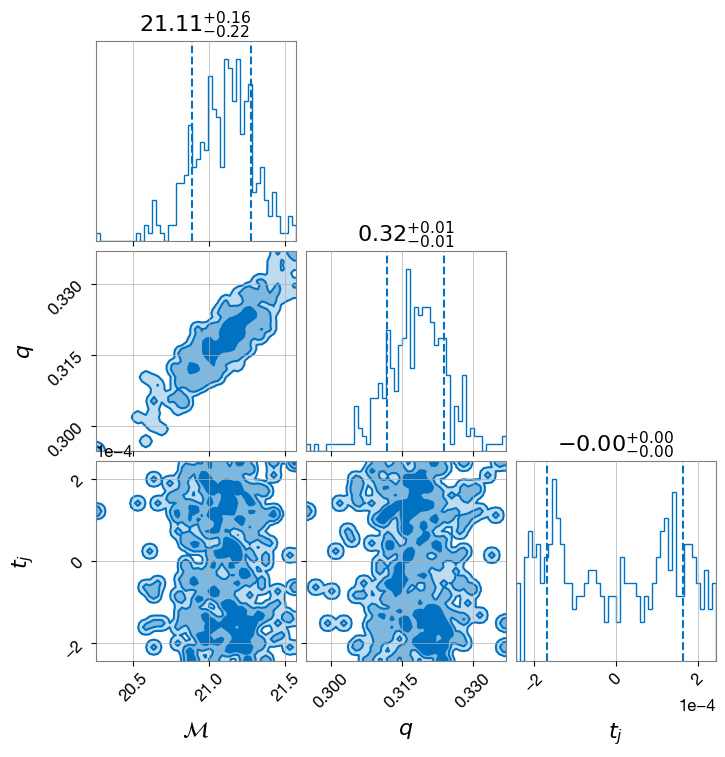

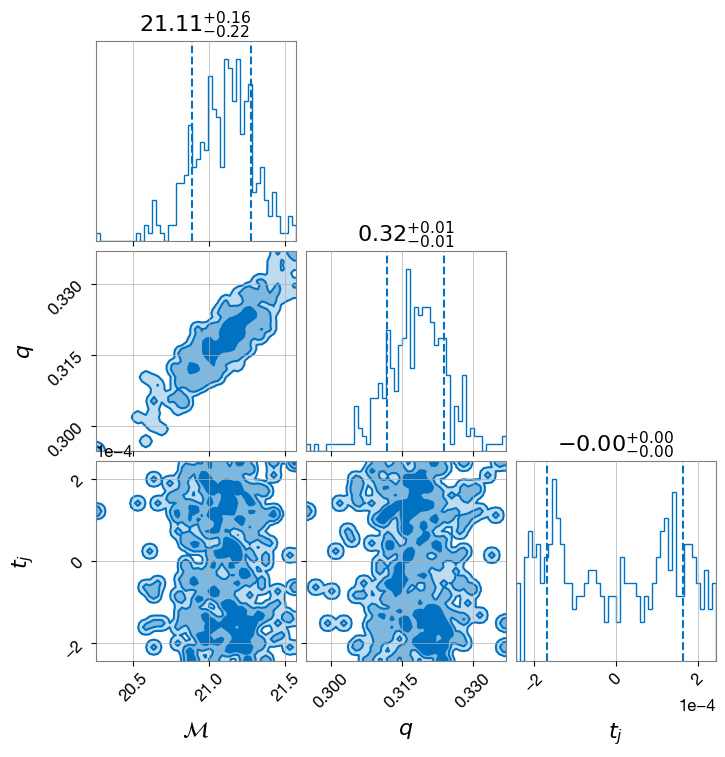

In [286]:
result_def.plot_corner(save=False)

Mc = 25.44238284530101 with a 90% C.I = 25.023467318685277 -> 26.87191686148563


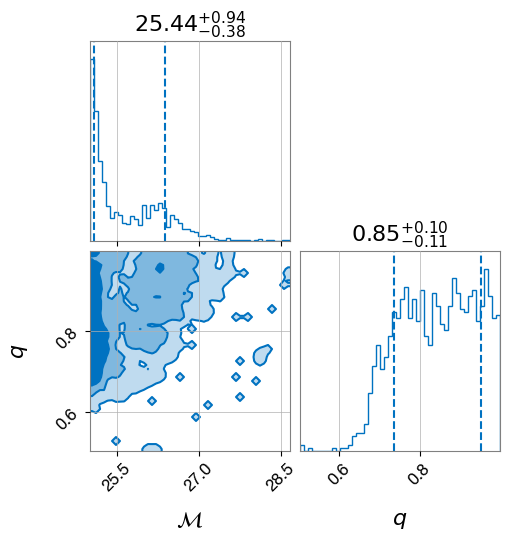

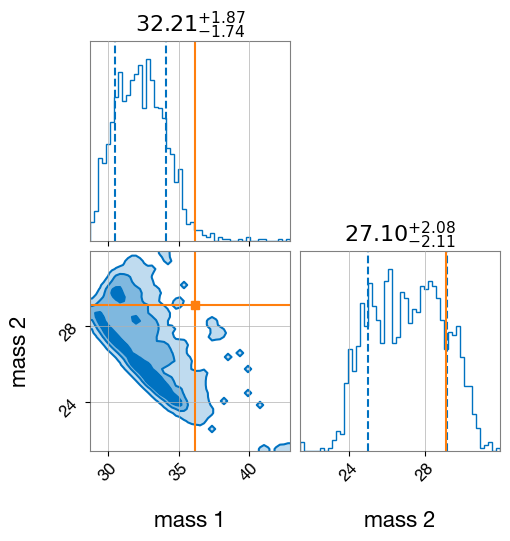

In [370]:
Mc = result_short.posterior["chirp_mass"].values

lower_bound = np.quantile(Mc, 0.05)
upper_bound = np.quantile(Mc, 0.95)
median = np.quantile(Mc, 0.5)
print("Mc = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

'''
fig, ax = plt.subplots()

ax.hist(result_short.posterior["chirp_mass"], bins=50)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
ax.axvline(median, color='C1')
ax.set_xlabel("chirp mass")
plt.show()
'''

result_short.plot_corner(parameters=["chirp_mass", "mass_ratio"], prior=True, save=False)
plt.show()

parameters = dict(mass_1=36.2, mass_2=29.1)
fig = result_short.plot_corner(parameters, save=False)
plt.show()

In [361]:
a=[1126258071.4748535, 1126258071.3989258, 1126259462.428955, 1126259462.4260254, 1126258071.2695312, 1126259462.4238281, 1126259462.4658203, 1126259462.4233398, 1126259462.4179688, 1126259632.368164, 1126259462.428711, 1126259462.4262695, 1126258071.2700195, 1126260910.3950195, 1126259462.4238281, 1126259462.4233398, 1126259462.4211426, 1126259462.4179688, 1126259462.416504, 1126258071.2580566, 1126259462.4780273, 1126259462.425537, 1126259462.4238281, 1126259462.4211426, 1126259462.4211426, 1126259462.4157715, 1126259462.4108887, 1126259462.4248047, 1126259462.423584, 1126259462.4223633, 1126259462.4211426, 1126259462.416504, 1126259462.4143066, 1126259462.409668, 1126259462.4221191, 1126259462.4208984, 1126259462.4160156, 1126259462.416504, 1126259462.4118652, 1126259462.4091797, 1126259462.4157715, 1126259462.4157715, 1126259462.4118652, 1126259462.4108887, 1126259462.4035645, 1126259462.4106445, 1126259462.4101562, 1126259462.4035645, 1126259462.3913574, 1126259462.402832, 1126259462.3986816, 1126259462.3901367, 1126259462.3901367, 1126259462.3850098, 1126259462.3793945]

(array([48.]),
 array([1.12625945e+09, 1.12625947e+09]),
 <BarContainer object of 1 artists>)

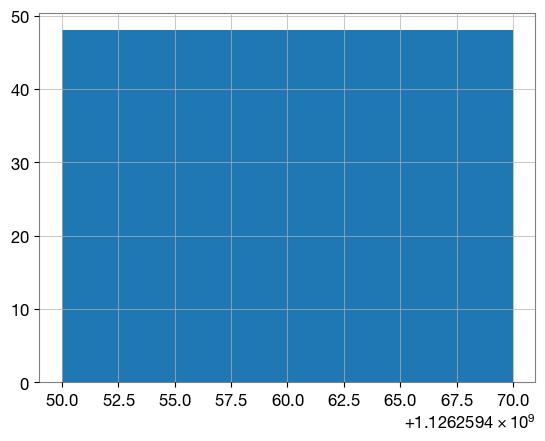

In [367]:
plt.hist(a,bins=np.arange(1126259450,1126259475,20))